In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
import torch
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## EDA for Segmentation

In [4]:
# Define path variables
TRAIN_CSV = r'segmentation/Metadata/test.csv'
TEST_CSV = r'segmentation/Metadata/train.csv'
SEGMENTATION_DIR = r'segmentation/'
TRAIN_DIR = {0: 'Training', 1: 'Testing'}

# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df_seg_train = pd.read_csv(TRAIN_CSV)
df_seg_test = pd.read_csv(TEST_CSV)
df = pd.concat([df_seg_train, df_seg_test])

In [6]:
df.head()

,filenames,img_size_x,img_size_y,masks,gt_size_x,gt_size_y,train_id,seg_dict,is_empty
0,patient101_frame01_slice1.png,232,256,patient101_frame01_gt_slice1.png,232,256,1,"{0: 58064, 170: 491, 255: 837}",0
1,patient101_frame01_slice2.png,232,256,patient101_frame01_gt_slice2.png,232,256,1,"{0: 56801, 85: 874, 170: 567, 255: 1150}",0
2,patient101_frame01_slice3.png,232,256,patient101_frame01_gt_slice3.png,232,256,1,"{0: 56701, 85: 917, 170: 578, 255: 1196}",0
3,patient101_frame01_slice4.png,232,256,patient101_frame01_gt_slice4.png,232,256,1,"{0: 56891, 85: 856, 170: 597, 255: 1048}",0
4,patient101_frame01_slice5.png,232,256,patient101_frame01_gt_slice5.png,232,256,1,"{0: 57044, 85: 738, 170: 574, 255: 1036}",0


In [7]:
df.shape

(2842, 9)

In [8]:
# We have dropped around 75 and 61 images with missing ground truth masks in the training and testing datasets respectively.
df.train_id.value_counts()

train_id
0    1841
1    1001
Name: count, dtype: int64

<Axes: xlabel='train_id'>

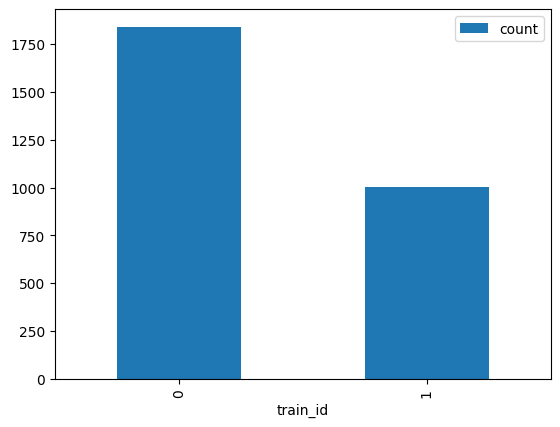

In [9]:
df.train_id.value_counts().plot(kind = 'bar', legend = ['Train', 'Test'])

## Explore the Data

In [10]:
def generate_sample_images(sample):
    
    imgs = sample.filenames
    train_ids = sample.train_id
    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()
    
    for i, (image_name, train_id) in enumerate(zip(imgs, train_ids)):
        img_path = os.path.join(SEGMENTATION_DIR, TRAIN_DIR[train_id], "Images", image_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title('{}'.format(image_name))
        ax[i].title.set_size(8)
        ax[i].imshow(image)

def generate_sample_masks(sample):
    
    masks = sample.masks
    train_ids = sample.train_id
    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, (mask_name, train_id) in enumerate(zip(masks, train_ids)):
        mask_path = os.path.join(SEGMENTATION_DIR, TRAIN_DIR[train_id], "Masks", mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

        ax[i].set_title("{}".format(mask_name))
        ax[i].title.set_size(8)
        ax[i].imshow(mask, cmap='gray')

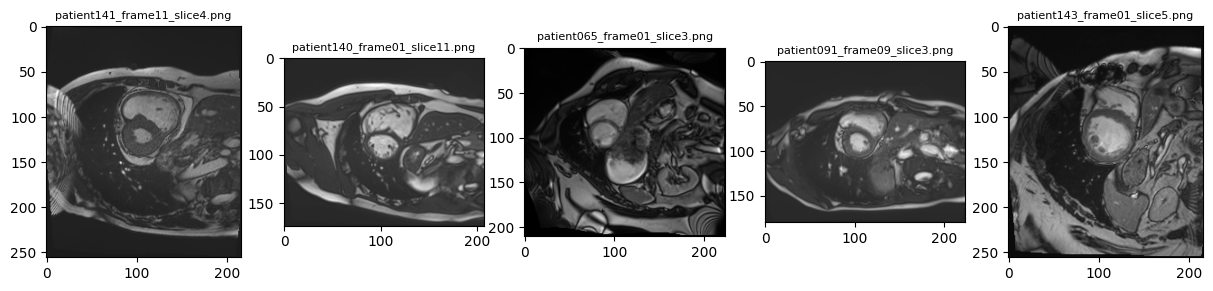

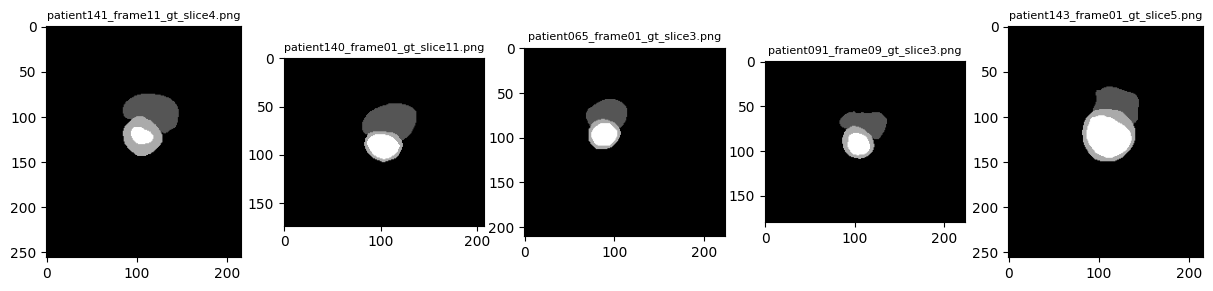

In [12]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]
generate_sample_images(sample)
generate_sample_masks(sample)

After visualization we can see that there are some masks that might be empty, some masks have 3,2, even 1 region. Need to check the mask balance  as well.

**61 masks are empty in Training Set and 75 masks are empty in Testing Set. We will drop these masks during Training.**

## Masks Distribution

## Split the Data

1. Split depending upon the patients (100 Train + 50 Test).
2. Split depending upon the frames (1841 Train + 1001 Test).

1841 Train is split further in Train and Validation.
1001 Test remains same.

In [13]:
df_train = df[(df.train_id == 0) & (df.is_empty == 0)]
df_test = df[(df.train_id == 1) & (df.is_empty == 0)]

In [14]:
# Split df_train in separate train and validation sets
train_df, val_df = train_test_split(df_train, test_size = 0.2, random_state = 42)

In [15]:
train_df.shape, val_df.shape

((1472, 9), (369, 9))

In [ ]:
train_df.head()

,filenames,img_size_x,img_size_y,masks,gt_size_x,gt_size_y,train_id,seg_dict,is_empty
588,patient032_frame12_slice2.png,240,256,patient032_frame12_gt_slice2.png,240,256,0,"{0: 60088, 170: 1057, 255: 295}",0
949,patient053_frame01_slice2.png,216,256,patient053_frame01_gt_slice2.png,216,256,0,"{0: 51235, 85: 1509, 170: 1044, 255: 1508}",0
1631,patient091_frame09_slice5.png,180,224,patient091_frame09_gt_slice5.png,180,224,0,"{0: 38833, 85: 646, 170: 393, 255: 448}",0
1719,patient095_frame12_slice3.png,180,224,patient095_frame12_gt_slice3.png,180,224,0,"{0: 37896, 85: 1308, 170: 665, 255: 451}",0
1338,patient076_frame12_slice3.png,256,256,patient076_frame12_gt_slice3.png,256,256,0,"{0: 63249, 85: 1034, 170: 873, 255: 380}",0


In [28]:
type(train_df.seg_dict[0])

str

In [29]:
import ast

In [37]:
df_train['seg_dict_parsed'] = df_train['seg_dict'].apply(ast.literal_eval)

# Step 2: Extract all keys into a flat list
all_keys = df_train['seg_dict_parsed'].apply(lambda d: list(d.keys())).sum()

# Step 3: Get unique values and sort
unique_values = sorted(set(all_keys))


C:\Users\Snehil Sanyal\AppData\Local\Temp\ipykernel_12296\2194595751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['seg_dict_parsed'] = df_train['seg_dict'].apply(ast.literal_eval)


In [38]:
df_train['seg_dict_parsed']

0       {0: 51669, 85: 1455, 170: 821, 255: 1351}
1       {0: 51506, 85: 1254, 170: 880, 255: 1656}
2        {0: 51607, 85: 998, 170: 939, 255: 1752}
3        {0: 51907, 85: 727, 170: 897, 255: 1765}
4        {0: 52274, 85: 512, 170: 888, 255: 1622}
                          ...                    
1836     {0: 62851, 85: 1560, 170: 941, 255: 312}
1837     {0: 63042, 85: 1431, 170: 909, 255: 282}
1838     {0: 63560, 85: 1116, 170: 720, 255: 268}
1839      {0: 64351, 85: 646, 170: 543, 255: 124}
1840       {0: 65108, 85: 363, 170: 162, 255: 31}
Name: seg_dict_parsed, Length: 1841, dtype: object

In [39]:
unique_values

[0, 85, 127, 170, 255]

In [40]:
rows_with_127 = df_train[df_train['seg_dict_parsed'].apply(lambda d: 127 in d.keys())]

In [41]:
rows_with_127

,filenames,img_size_x,img_size_y,masks,gt_size_x,gt_size_y,train_id,seg_dict,is_empty,seg_dict_parsed
522,patient028_frame09_slice8.png,224,256,patient028_frame09_gt_slice8.png,224,256,0,"{0: 56609, 127: 11, 255: 724}",0,"{0: 56609, 127: 11, 255: 724}"
1343,patient076_frame12_slice8.png,256,256,patient076_frame12_gt_slice8.png,256,256,0,"{0: 65243, 127: 32, 255: 261}",0,"{0: 65243, 127: 32, 255: 261}"


img_size_x
216    496
256    310
208    250
224    119
154     89
174     88
232     78
192     71
180     61
240     55
184     49
200     34
168     28
222     20
248     20
428     16
276     16
210     15
214     14
264     12
Name: count, dtype: int64

## Training Parameters

In [16]:
# Define hyperparameters
EPOCHS = 20        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 224     # Size of image
BATCH_SIZE = 32    # Batch size 

# Define pretrained encoder model and weights
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

## Data Augmentation

In [21]:
import albumentations as A

In [22]:
# Define the augmentations
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p = 0.5), # Horizontal Flip with 0.5 probability
        A.VerticalFlip(p = 0.5),  # Vertical Flip with 0.5 probability
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.3),
        #A.GaussNoise(std_range=(0.1, 0.2), p = 0.2)
    ], is_check_shapes = False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        #A.Normalize(mean=(0.5,), std=(0.5,)),
    ], is_check_shapes = False)
    
def get_test_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        #A.Normalize(mean=(0.5,), std=(0.5,)),
    ], is_check_shapes=False)

## Processing the Dataset

In [23]:
from torch.utils.data import Dataset

In [43]:
## Create ACDC Dataset for Segmentation

class ACDCSegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df 
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        train_id  = sample.train_id
        if train_id==0:
            FOLDER_NAME = 'Training'
        if train_id==1:
            FOLDER_NAME = 'Testing'
        image_path = os.path.join(SEGMENTATION_DIR, FOLDER_NAME, "Images", sample.filenames)
        mask_path = os.path.join(SEGMENTATION_DIR, FOLDER_NAME, "Masks", sample.masks)

        # Read images and masks 
        image =  np.array(Image.open(image_path))
        image = np.expand_dims(image, axis = -1)
        mask = np.array(Image.open(mask_path))
        mask = np.expand_dims(mask, axis = -1)
        # print(f"Shapes of images before augmentation: {image.shape}")
        # print(f"Shapes of masks before augmentation: {mask.shape}")

        # Apply augmentations
        if self.augs:
            data = self.augs(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # Transpose Image format in PyTorch Format
        # (H, W, C) --> (C, H, W)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # Normalize the images and masks 
        image = torch.Tensor(image) / 255.

        # Convert mask values [0, 85, 170, 255] → [0, 1, 2, 3]
        mask = torch.Tensor(mask)
        #mask = (mask / 85).long()  

        # mask = torch.round(torch.Tensor(mask))
        mask = torch.round(mask / 85).long()

        return image, mask

In [ ]:
# Processed train and validation data
train_data = ACDCSegmentationDataset(train_df, get_train_augs())
val_data = ACDCSegmentationDataset(val_df, get_val_augs())
test_data = ACDCSegmentationDataset(df_test, get_test_augs())

In [62]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")
print(f"Size of Testset : {len(test_data)}")

Size of Trainset : 1472
Size of Validset : 369
Size of Testset : 1001


In [63]:
train_data[0][0].shape, train_data[0][1].shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

In [64]:
def processed_image(idx):
    image, mask = train_data[idx]

    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(image, (1, 2, 0)), cmap = 'gray')
    plt.axis('off')
    plt.title('IMAGE')

    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(mask, (1, 2, 0)), cmap = 'gray')
    plt.axis('off')
    plt.title('GROUND TRUTH')
    plt.show()

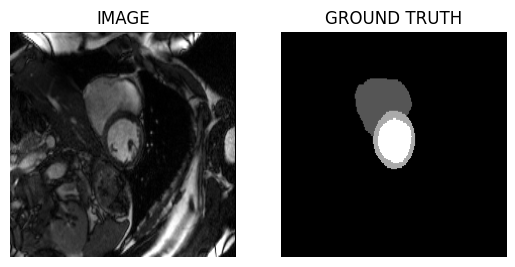

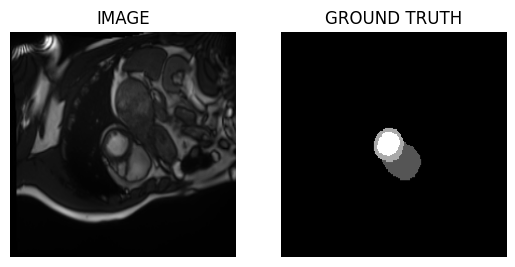

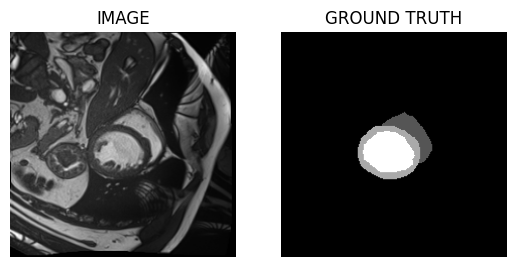

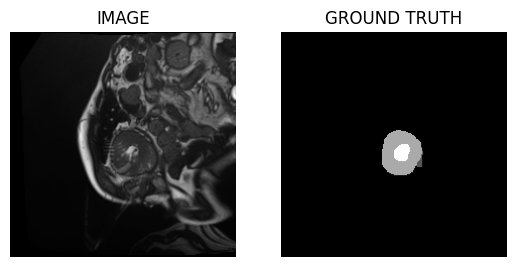

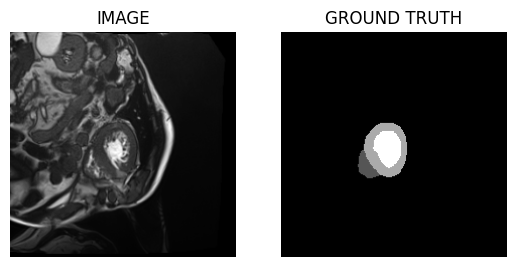

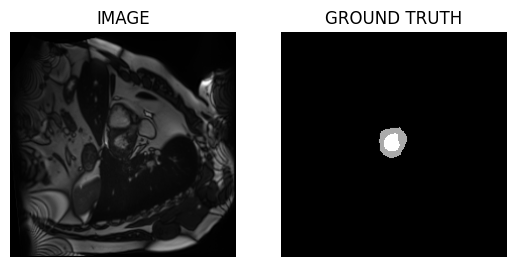

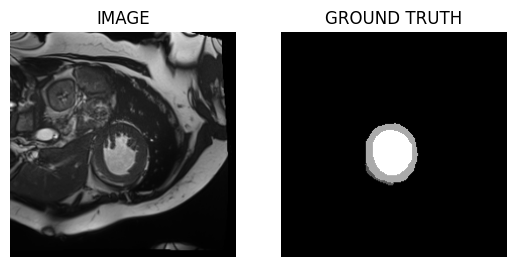

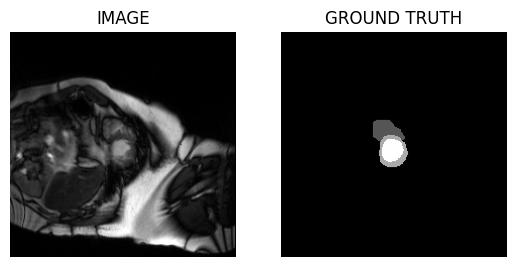

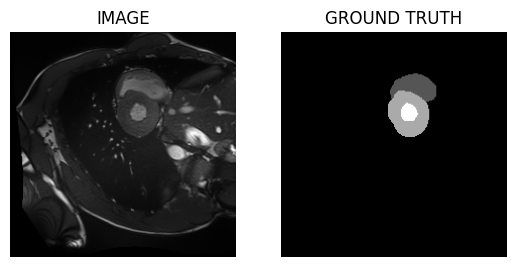

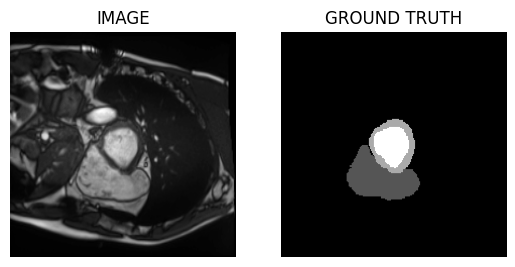

In [65]:
for i in np.random.randint(0, len(train_data), 10):
    processed_image(i)

## Load Dataset into Batches

In [66]:
from torch.utils.data import DataLoader

In [67]:
trainloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
valloader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 46
Total number of batches in Val Loader: 12


In [68]:
for idx, (image, mask) in enumerate(valloader):
    print(f"Size of {idx+1}th batch of images: {image.shape}")
    print(f"Size of {idx+1}th batch of masks: {mask.shape}")

Size of 1th batch of images: torch.Size([32, 1, 224, 224])
Size of 1th batch of masks: torch.Size([32, 1, 224, 224])
Size of 2th batch of images: torch.Size([32, 1, 224, 224])
Size of 2th batch of masks: torch.Size([32, 1, 224, 224])
Size of 3th batch of images: torch.Size([32, 1, 224, 224])
Size of 3th batch of masks: torch.Size([32, 1, 224, 224])
Size of 4th batch of images: torch.Size([32, 1, 224, 224])
Size of 4th batch of masks: torch.Size([32, 1, 224, 224])
Size of 5th batch of images: torch.Size([32, 1, 224, 224])
Size of 5th batch of masks: torch.Size([32, 1, 224, 224])
Size of 6th batch of images: torch.Size([32, 1, 224, 224])
Size of 6th batch of masks: torch.Size([32, 1, 224, 224])
Size of 7th batch of images: torch.Size([32, 1, 224, 224])
Size of 7th batch of masks: torch.Size([32, 1, 224, 224])
Size of 8th batch of images: torch.Size([32, 1, 224, 224])
Size of 8th batch of masks: torch.Size([32, 1, 224, 224])
Size of 9th batch of images: torch.Size([32, 1, 224, 224])
Size 

## Create Segmentation Model

In [ ]:
#!pip install segmentation-models-pytorch --quiet


**From:** https://smp.readthedocs.io/en/latest/losses.html 

segmentation_models_pytorch.losses.constants.MULTICLASS_MODE: str = 'multiclass'
Loss multiclass mode suppose you are solving multi-class segmentation task. That mean you have C = 1..N classes which have unique label values, classes are mutually exclusive and all pixels are labeled with theese values. Target mask shape - (N, H, W), model output mask shape (N, C, H, W).


In [69]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.losses import SoftCrossEntropyLoss, DiceLoss

In [74]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name = ENCODER,
            encoder_weights = None,
            in_channels = 1, # 1 Channel for grayscale images
            classes = 4,  # 4 classes
            activation = None)  

    def forward(self, images, masks=None):
        logits = self.model(images)  # (B, 4, H, W)

        if masks is not None:
            # masks should be (B, H, W) with class labels 0-3
            loss1 = DiceLoss(mode = 'multiclass')(logits, masks)
            loss2 = SoftCrossEntropyLoss(smooth_factor=0.0)(logits, masks)
            return logits, loss1 + loss2

        # During Inference I don't want to compute the loss, just the logits will do.
        return logits

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self, model_name='UnetPlusPlus', encoder_name='resnet34', encoder_weights='imagenet',
                 in_channels=1, num_classes=4):
        super(SegmentationModel, self).__init__()

        self.model_name = model_name.lower()
        self.num_classes = num_classes

        # Models from segmentation_models_pytorch
        if self.model_name in ['unet', 'unetplusplus', 'fpn', 'pspnet', 'deeplabv3', 'deeplabv3+', 'linknet', 'manet', 'pan']:
            ModelClass = getattr(smp, model_name)
            self.model = ModelClass(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=in_channels,
                classes=num_classes,
                activation=None
            )

        # UPerNet, Segformer, DPT from HuggingFace Transformers (or other libs)
        elif self.model_name == 'segformer':
            config = SegformerConfig.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
            config.num_channels = in_channels
            config.num_labels = num_classes
            self.model = SegformerForSemanticSegmentation.from_pretrained(
                "nvidia/segformer-b0-finetuned-ade-512-512",
                config=config
            )

        elif self.model_name == 'upernet' or self.model_name == 'dpt':
            raise NotImplementedError(f"{self.model_name} requires special pre-processing and architecture wrapping.")

        else:
            raise ValueError(f"Model {model_name} not supported.")

    def forward(self, images, masks=None):
        if self.model_name == 'segformer':
            # Segformer expects dict input
            logits = self.model(pixel_values=images).logits  # (B, num_classes, H, W)
        else:
            logits = self.model(images)

        if masks is not None:
            loss1 = DiceLoss(mode='multiclass')(logits, masks)
            loss2 = SoftCrossEntropyLoss(smooth_factor=0.0)(logits, masks)
            return logits, loss1 + loss2

        return logits


In [75]:
DEVICE

device(type='cuda', index=0)

In [76]:
model = SegmentationModel();
model.to(DEVICE)

SegmentationModel(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gat

## Create Training and Validation Function

In [77]:
# Function to Train the model (During Training we want logits and loss)
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [78]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

## Model Training

In [79]:
# Define the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [80]:
# Training and evaluation loop
best_val_loss = 1e9
tr_loss, va_loss = [], [] 
for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)
    tr_loss.append(train_loss)
    va_loss.append(val_loss)
    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")
        
        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|██████████| 12/12 [00:03<00:00,  3.64it/s]


MODEL SAVED
 Epoch 1 Train Loss 1.0938201728074446 Val Loss 0.7994725952545801


100%|██████████| 12/12 [00:03<00:00,  3.80it/s]


MODEL SAVED
 Epoch 2 Train Loss 0.705572881128477 Val Loss 0.6238299012184143


100%|██████████| 12/12 [00:03<00:00,  3.86it/s]


MODEL SAVED
 Epoch 3 Train Loss 0.5127607499775679 Val Loss 0.4473103880882263


100%|██████████| 12/12 [00:03<00:00,  3.88it/s]


MODEL SAVED
 Epoch 4 Train Loss 0.33578557747861615 Val Loss 0.2802577589948972


100%|██████████| 12/12 [00:03<00:00,  3.84it/s]


MODEL SAVED
 Epoch 5 Train Loss 0.2528321464424548 Val Loss 0.24344918380180994


100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


MODEL SAVED
 Epoch 6 Train Loss 0.21512444155371707 Val Loss 0.181861013174057


100%|██████████| 12/12 [00:02<00:00,  4.15it/s]


 Epoch 7 Train Loss 0.18640849415374838 Val Loss 0.19128970305124918


100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


MODEL SAVED
 Epoch 8 Train Loss 0.16226479378731354 Val Loss 0.15603548164168993


100%|██████████| 12/12 [00:02<00:00,  4.21it/s]


MODEL SAVED
 Epoch 9 Train Loss 0.15139459300300348 Val Loss 0.14862330506245294


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


 Epoch 10 Train Loss 0.13984415404822514 Val Loss 0.15061310678720474


100%|██████████| 12/12 [00:02<00:00,  4.26it/s]


MODEL SAVED
 Epoch 11 Train Loss 0.13561976814399596 Val Loss 0.1340996709962686


100%|██████████| 12/12 [00:02<00:00,  4.22it/s]


MODEL SAVED
 Epoch 12 Train Loss 0.1264893117806186 Val Loss 0.1258411481976509


100%|██████████| 12/12 [00:02<00:00,  4.15it/s]


 Epoch 13 Train Loss 0.11699530579473662 Val Loss 0.1275269314646721


100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


MODEL SAVED
 Epoch 14 Train Loss 0.11718699287461198 Val Loss 0.12428787474830945


100%|██████████| 12/12 [00:02<00:00,  4.26it/s]


MODEL SAVED
 Epoch 15 Train Loss 0.1136293602378472 Val Loss 0.11401413505276044


100%|██████████| 12/12 [00:02<00:00,  4.21it/s]


MODEL SAVED
 Epoch 16 Train Loss 0.10894186017305954 Val Loss 0.11275621814032395


100%|██████████| 12/12 [00:02<00:00,  4.21it/s]


MODEL SAVED
 Epoch 17 Train Loss 0.10397954641476921 Val Loss 0.1118486151099205


100%|██████████| 12/12 [00:02<00:00,  4.27it/s]


 Epoch 18 Train Loss 0.10225105884930362 Val Loss 0.11379820667207241


100%|██████████| 12/12 [00:02<00:00,  4.26it/s]


MODEL SAVED
 Epoch 19 Train Loss 0.09861315398112587 Val Loss 0.10445371642708778


100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

 Epoch 20 Train Loss 0.09436133212369421 Val Loss 0.10813973347345988


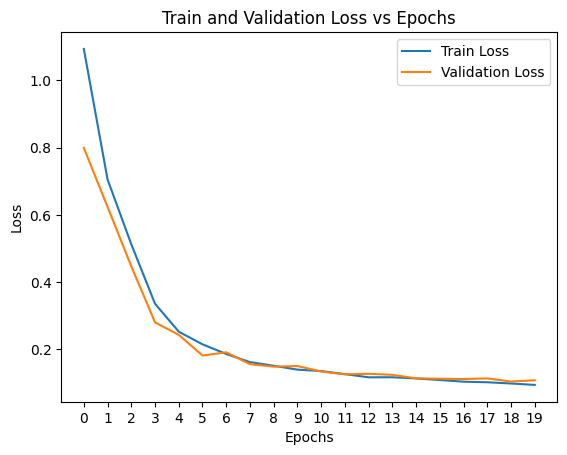

In [81]:
plt.title("Train and Validation Loss vs Epochs")
plt.plot(tr_loss)
plt.plot(va_loss)
plt.xticks(np.arange(0, EPOCHS, 1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train Loss', 'Validation Loss'])   
plt.show()

In [ ]:
model

## Inference

In [44]:
test_data[0][0].shape, test_data[0][1].shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

In [82]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Function to output the prediction mask (Binary Segmentation, in case of only background and foreground)
def make_inference(idx):
    image, mask = test_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0
    
    return image, mask, pred_mask

C:\Users\Snehil Sanyal\AppData\Local\Temp\ipykernel_12296\2006671271.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


In [83]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# New inference function keeping in mind Softmax + Argmax is required for multi class segmentation

def make_inference(idx):
    image, mask = test_data[idx]
    image = image.to(DEVICE).unsqueeze(0)  # (1, C, H, W)
    
    with torch.no_grad():
        logits = model(image)  # (1, 4, H, W)
        probs = torch.softmax(logits, dim=1)  # Convert to probabilities across classes
        pred_mask = torch.argmax(probs, dim=1).squeeze(0)  # (H, W), class labels [0, 1, 2, 3]

    return image.squeeze(0).cpu(), mask, pred_mask.cpu()

C:\Users\Snehil Sanyal\AppData\Local\Temp\ipykernel_12296\788486073.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Helper function to compute metrics
def compute_metrics(mask, pred_mask, num_classes):
    # Flatten both masks to 1D arrays for evaluation
    mask = mask.flatten()
    pred_mask = pred_mask.flatten()

    # Initialize lists to store per-class metrics
    precision_list = []
    recall_list = []
    f1_list = []
    iou_list = []

    # Loop through each class (excluding background if you have background as class 0)
    for c in range(1, num_classes):
        # Get binary values for current class
        y_true = (mask == c).astype(np.float32)
        y_pred = (pred_mask == c).astype(np.float32)

        # Compute Precision, Recall, F1 for the current class
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # Compute IoU for the current class
        intersection = np.sum(y_true * y_pred)
        union = np.sum(y_true) + np.sum(y_pred) - intersection
        iou = intersection / union if union > 0 else 0.0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        iou_list.append(iou)

    # Calculate Mean IoU (mIoU), Mean F1, etc.
    mean_iou = np.mean(iou_list)
    mean_f1 = np.mean(f1_list)
    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)

    return {
        'precision': precision_list,
        'recall': recall_list,
        'f1': f1_list,
        'iou': iou_list,
        'mean_iou': mean_iou,
        'mean_f1': mean_f1,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall
    }

# Example inference loop
num_classes = 4  # including background
sample_idx = 0  # Index of the sample you want to test

image, mask, pred_mask = make_inference(sample_idx)

metrics = compute_metrics(mask.numpy(), pred_mask.numpy(), num_classes)
print(metrics)

C:\Users\Snehil Sanyal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'precision': [0.0, 0.7852193995381063, 0.8830188679245283], 'recall': [0.0, 0.7962529274004684, 0.9957446808510638], 'f1': [0.0, 0.7906976744186046, 0.936], 'iou': [0.0, 0.65384614, 0.87969923], 'mean_iou': 0.5111818, 'mean_f1': 0.5755658914728682, 'mean_precision': 0.5560794224875448, 'mean_recall': 0.5973325360838441}


In [86]:
def compute_metrics_for_dataset(test_data, num_classes):
    all_iou = []
    all_dice = []
    
    for idx in range(len(test_data)):
        # Perform inference for the current sample
        image, mask, pred_mask = make_inference(idx)
        
        # Compute metrics for the current sample
        metrics = compute_metrics(mask.numpy(), pred_mask.numpy(), num_classes)
        
        # Append per-class IoU and Dice to the respective lists
        all_iou.append(metrics['iou'])
        all_dice.append(metrics['f1'])  # F1 is the Dice coefficient in segmentation tasks

    # Calculate mean IoU and Dice for the entire dataset (mean across all images)
    mean_iou = np.mean(all_iou, axis=0)  # Mean IoU per class
    mean_dice = np.mean(all_dice, axis=0)  # Mean Dice per class
    
    # Overall Mean IoU and Mean Dice (averaged across all classes)
    mean_iou_overall = np.mean(mean_iou)
    mean_dice_overall = np.mean(mean_dice)
    
    return {
        'mean_iou': mean_iou_overall,
        'mean_dice': mean_dice_overall,
        'mean_iou_per_class': mean_iou,
        'mean_dice_per_class': mean_dice
    }

# Example usage
num_classes = 4  # Including background
metrics = compute_metrics_for_dataset(test_data, num_classes)
print("Mean IoU for all classes:", metrics['mean_iou_per_class'])
print("Overall Mean IoU:", metrics['mean_iou'])
print("Mean Dice for all classes:", metrics['mean_dice_per_class'])
print("Overall Mean Dice:", metrics['mean_dice'])


C:\Users\Snehil Sanyal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Snehil Sanyal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Snehil Sanyal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

KeyboardInterrupt: 

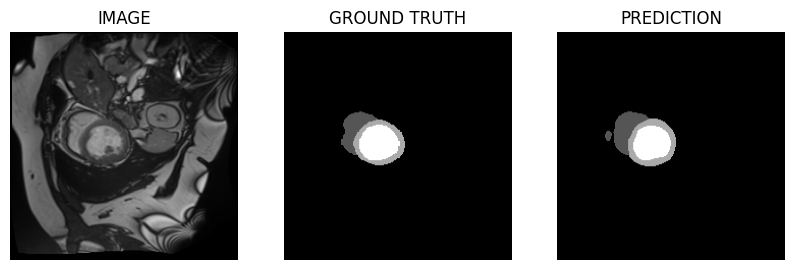

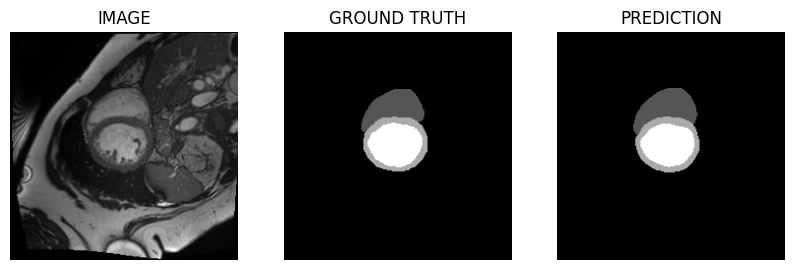

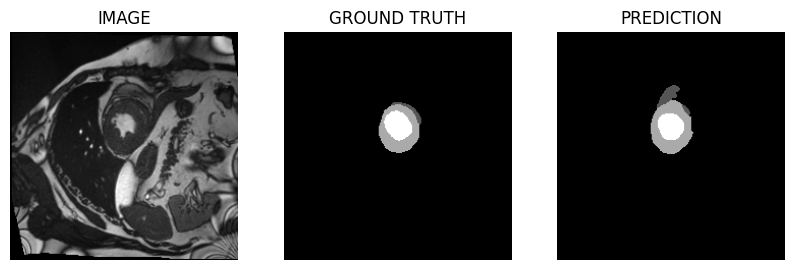

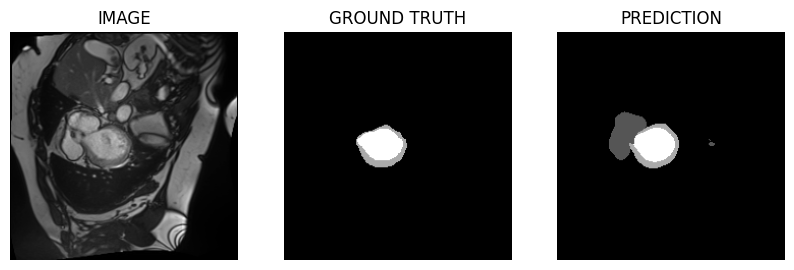

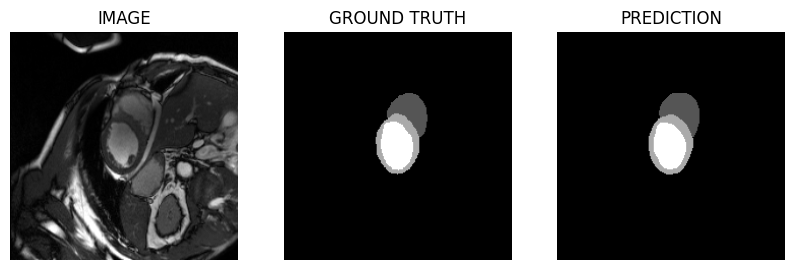

In [87]:
# Compare predictions with original
for i in np.random.randint(0, len(test_data), 5):
    image, mask, pred_mask = make_inference(i)
    
    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)), cmap = 'gray')
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    ## This was with previous inference function.
    # plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    # After new inference function
    plt.imshow(np.transpose(np.transpose(pred_mask)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

In [88]:
tr_loss

[1.0938201728074446,
 0.705572881128477,
 0.5127607499775679,
 0.33578557747861615,
 0.2528321464424548,
 0.21512444155371707,
 0.18640849415374838,
 0.16226479378731354,
 0.15139459300300348,
 0.13984415404822514,
 0.13561976814399596,
 0.1264893117806186,
 0.11699530579473662,
 0.11718699287461198,
 0.1136293602378472,
 0.10894186017305954,
 0.10397954641476921,
 0.10225105884930362,
 0.09861315398112587,
 0.09436133212369421]

In [89]:
va_loss

[0.7994725952545801,
 0.6238299012184143,
 0.4473103880882263,
 0.2802577589948972,
 0.24344918380180994,
 0.181861013174057,
 0.19128970305124918,
 0.15603548164168993,
 0.14862330506245294,
 0.15061310678720474,
 0.1340996709962686,
 0.1258411481976509,
 0.1275269314646721,
 0.12428787474830945,
 0.11401413505276044,
 0.11275621814032395,
 0.1118486151099205,
 0.11379820667207241,
 0.10445371642708778,
 0.10813973347345988]

In [90]:
image.shape, mask.shape, pred_mask.shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([224, 224]))

The model performs fairly decent but there is still room for improvement. To further improve the performance the below mentioned steps can be 

**Steps to improve the model performance:**
- Try running the model for more epochs
- Try using different model architectures
- Try using different encoder models
- Try using more efficient methods such as early stopping to prevent overfitting
- Try using differnt learning rate schedulers to reduce learning rate near convergence region.